réalisé avec le dataset SessionAllLayers

réalisé avec le dataset FlowAllLayers

réalisé avec le dataset SessionL7

réalisé avec le dataset FlowL7

In [1]:
!pip install idx2numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7917 sha256=38f69963fcf89f2595b3990ad65fef52a47ce4041de05c4da3e1f852c2e05163
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy


# Creation du dataset

## Import des données

In [107]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import itertools
from collections import defaultdict

In [17]:
with open("train-images-idx3-ubyte", 'rb') as file:
    data_train = idx2numpy.convert_from_file(file)
print(type(data_train))

<class 'numpy.ndarray'>


In [18]:
with open("train-labels-idx1-ubyte", 'rb') as file:
    label_train = idx2numpy.convert_from_file(file)
print(type(label_train))

<class 'numpy.ndarray'>


In [19]:
with open("test-images-idx3-ubyte", 'rb') as file:
    data_test = idx2numpy.convert_from_file(file)
print(type(data_test))

<class 'numpy.ndarray'>


In [20]:
with open("test-labels-idx1-ubyte", 'rb') as file:
    label_test = idx2numpy.convert_from_file(file)
print(type(label_test))

<class 'numpy.ndarray'>


## Exploration Datas

<BarContainer object of 12 artists>

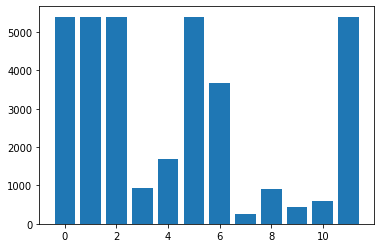

In [21]:
dico={}
for element in label_train:
  dico[element] = dico.get(element, 0) + 1
dico

plt.bar(dico.keys(), dico.values())

In [22]:
nb_classes = len(dico)

In [23]:
batch_size = 32

## dataset cnn 1d

In [24]:
# Conv 1D
X_1d = tf.reshape(data_train, [-1, 784, 1]) # -1 is to get the lenght of the sample data
X_1d.shape

TensorShape([35501, 784, 1])

In [25]:
y = tf.one_hot(label_train, nb_classes)
y.shape

TensorShape([35501, 12])

In [26]:
ds_1d = tf.data.Dataset.from_tensor_slices((X_1d, y))

In [27]:
n = ds_1d.cardinality().numpy()

ds_1d = ds_1d.shuffle(n, reshuffle_each_iteration=True)
ds_1d = ds_1d.batch(batch_size).prefetch(batch_size).cache()

In [28]:
n_new = ds_1d.cardinality().numpy()

ds_estim_1d = ds_1d.take(int(n_new * 0.8)) # Création du dataset d'estimation
ds_valid_1d = ds_1d.skip(int(n_new * 0.8)).take(int(n_new * 0.2)) # Création du dataset de validation

In [29]:
# Création du dataset de test
X_test_1d = tf.reshape(data_test, [-1, 784, 1])
y_test = tf.one_hot(label_test, nb_classes)
ds_test_1d = tf.data.Dataset.from_tensor_slices((X_test_1d, y_test))
ds_test_1d = ds_test_1d.batch(batch_size).prefetch(batch_size).cache()

## dataset cnn 2d

In [30]:
# Conv 2D
X_2d = tf.reshape(data_train, [-1, 28, 28, 1]) # -1 is to get the lenght of the sample data
X_2d.shape

TensorShape([35501, 28, 28, 1])

In [31]:
ds_2d = tf.data.Dataset.from_tensor_slices((X_2d, y))
n = ds_2d.cardinality().numpy()

ds_2d = ds_2d.shuffle(n, reshuffle_each_iteration=True)
ds_2d = ds_2d.batch(batch_size).prefetch(batch_size).cache()

n_new = ds_2d.cardinality().numpy()

ds_estim_2d = ds_2d.take(int(n_new * 0.8)) # Création du dataset d'estimation
ds_valid_2d = ds_2d.skip(int(n_new * 0.8)).take(int(n_new * 0.2)) # Création du dataset de validation

In [32]:
# Création du dataset de test
X_test_2d = tf.reshape(data_test, [-1, 28, 28, 1])
ds_test_2d = tf.data.Dataset.from_tensor_slices((X_test_2d, y_test))
ds_test_2d = ds_test_2d.batch(batch_size).prefetch(batch_size).cache()

# Modèle

## CNN 1D

In [ ]:
def build_CNN_1D(input_dim, output_dim):
  
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Input(shape=input_dim))

  model.add(tf.keras.layers.Conv1D(32, kernel_size=2, strides=1, padding='same'))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling1D(strides=3, padding='same'))

  model.add(tf.keras.layers.Conv1D(64, kernel_size=2, strides=1, padding='same'))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling1D(strides=3, padding='same'))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1024))
  model.add(tf.keras.layers.Dropout(rate=0.3))

  model.add(tf.keras.layers.Dense(output_dim, activation="softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.95, beta_2 = 0.999, epsilon = 1e-08)
  loss = tf.keras.losses.CategoricalCrossentropy()
  accuracy = tf.keras.metrics.Accuracy()

  model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

  return model

In [ ]:
cnn_1d = build_CNN_1D(input_dim=X_1d.shape[1:], output_dim=y.shape[1])
cnn_1d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 784, 32)           96        
                                                                 
 activation (Activation)     (None, 784, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 262, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 262, 64)           4160      
                                                                 
 activation_1 (Activation)   (None, 262, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 88, 64)           0         
 1D)                                                    

In [ ]:
epochs = 10
training_1d = cnn_1d.fit(ds_estim_1d, epochs=epochs, validation_data=ds_valid_1d)

Epoch 1/10
730/730 [==============================] - 15s 17ms/step - loss: 4.6015 - accuracy: 0.7334 - val_loss: 0.5788 - val_accuracy: 0.7989
Epoch 2/10
730/730 [==============================] - 9s 12ms/step - loss: 0.5651 - accuracy: 0.8121 - val_loss: 0.4616 - val_accuracy: 0.8468
Epoch 3/10
730/730 [==============================] - 7s 9ms/step - loss: 0.4977 - accuracy: 0.8300 - val_loss: 0.4346 - val_accuracy: 0.8472
Epoch 4/10
730/730 [==============================] - 7s 10ms/step - loss: 0.4747 - accuracy: 0.8359 - val_loss: 0.4114 - val_accuracy: 0.8582
Epoch 5/10
730/730 [==============================] - 7s 10ms/step - loss: 0.4469 - accuracy: 0.8429 - val_loss: 0.4103 - val_accuracy: 0.8314
Epoch 6/10
730/730 [==============================] - 7s 9ms/step - loss: 0.4350 - accuracy: 0.8479 - val_loss: 0.4035 - val_accuracy: 0.8534
Epoch 7/10
730/730 [==============================] - 7s 9ms/step - loss: 0.4156 - accuracy: 0.8543 - val_loss: 0.3599 - val_accuracy: 0.8511
E

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


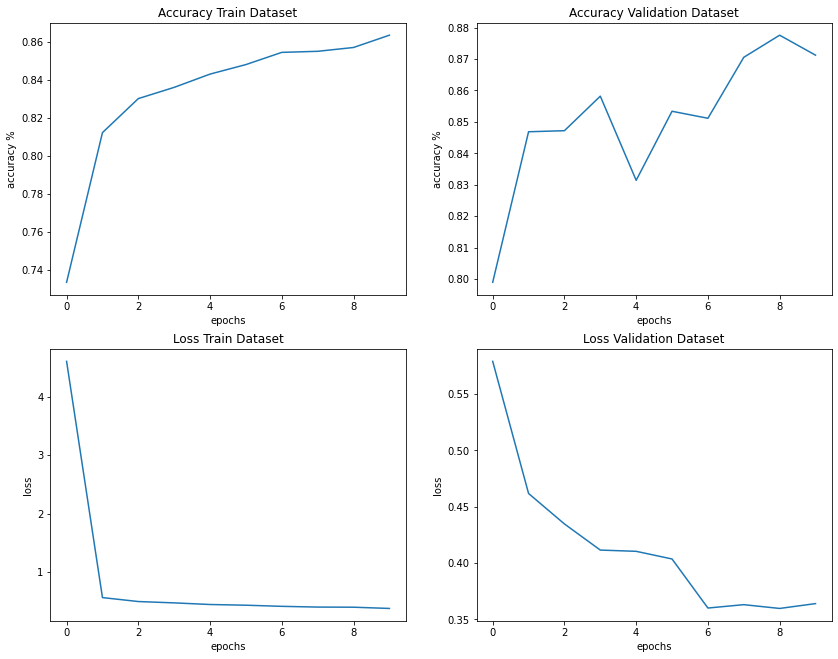

In [ ]:
print(training_1d.history.keys())
estim_acc = training_1d.history['accuracy']
valid_acc = training_1d.history['val_accuracy']
estim_loss = training_1d.history['loss']
valid_loss = training_1d.history['val_loss']

### Plots
plt.figure(figsize=(14,11))
plt.subplot(2,2,1)
plt.plot(estim_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Train Dataset')
plt.subplot(2,2,2)
plt.plot(valid_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Validation Dataset') 
plt.subplot(2,2,3)
plt.plot(estim_loss)
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Loss Train Dataset') 
plt.subplot(2,2,4)
plt.plot(valid_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss Validation Dataset') 
plt.show()

In [ ]:
cnn_1d.evaluate(ds_test_1d)

102/102 [==============================] - 1s 7ms/step - loss: 0.5695 - accuracy: 0.8212


[0.5694817304611206, 0.8212083578109741]

In [ ]:
cnn_1d.save('cnn_1d.h5')

## CNN 2D

In [ ]:
def build_CNN_2D(input_dim, output_dim):
  
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Input(shape=input_dim))

  model.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=1, padding='same'))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(strides=2, padding='same'))

  model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same'))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(strides=2, padding='same'))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1024))
  model.add(tf.keras.layers.Dropout(rate=0.3))

  model.add(tf.keras.layers.Dense(output_dim, activation="softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.95, beta_2 = 0.999, epsilon = 1e-08)
  loss = tf.keras.losses.CategoricalCrossentropy()
  accuracy = tf.keras.metrics.Accuracy()

  model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

  return model

In [ ]:
cnn_2d = build_CNN_2D(input_dim=X_2d.shape[1:], output_dim=y.shape[1])
cnn_2d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 activation_2 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 activation_3 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [ ]:
epochs = 10
training_2d = cnn_2d.fit(ds_estim_2d, epochs=epochs, validation_data=ds_valid_2d)

Epoch 1/10
365/365 [==============================] - 6s 14ms/step - loss: 2.4627 - accuracy: 0.5642 - val_loss: 0.9158 - val_accuracy: 0.6449
Epoch 2/10
365/365 [==============================] - 7s 17ms/step - loss: 0.7958 - accuracy: 0.7024 - val_loss: 0.6926 - val_accuracy: 0.7431
Epoch 3/10
365/365 [==============================] - 6s 16ms/step - loss: 0.6849 - accuracy: 0.7483 - val_loss: 0.6330 - val_accuracy: 0.7649
Epoch 4/10
365/365 [==============================] - 6s 15ms/step - loss: 0.6471 - accuracy: 0.7600 - val_loss: 0.5835 - val_accuracy: 0.7871
Epoch 5/10
365/365 [==============================] - 4s 11ms/step - loss: 0.5844 - accuracy: 0.7867 - val_loss: 0.5217 - val_accuracy: 0.8086
Epoch 6/10
365/365 [==============================] - 4s 11ms/step - loss: 0.5566 - accuracy: 0.7955 - val_loss: 0.5189 - val_accuracy: 0.8077
Epoch 7/10
365/365 [==============================] - 4s 11ms/step - loss: 0.5221 - accuracy: 0.8065 - val_loss: 0.4907 - val_accuracy: 0.8073

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


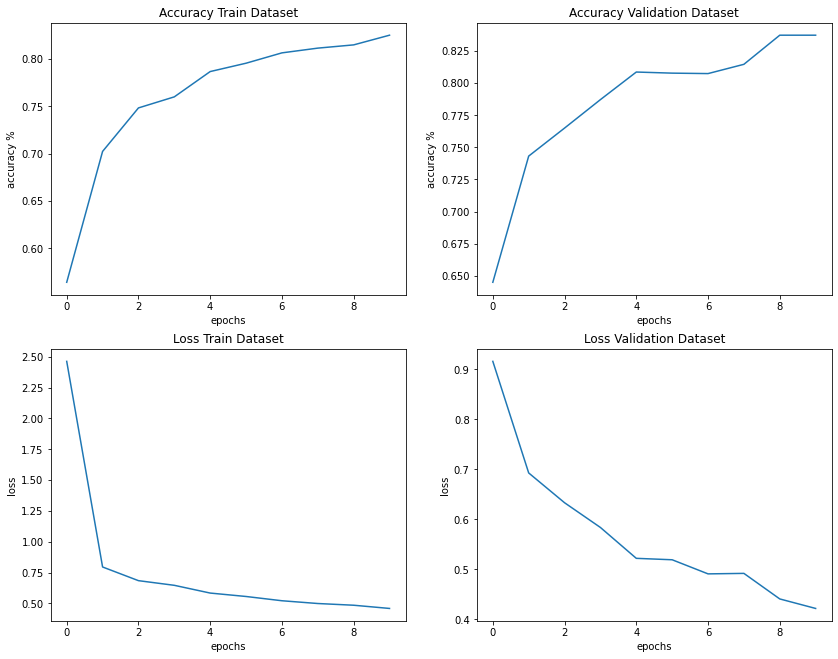

In [ ]:
print(training_2d.history.keys())
estim_acc = training_2d.history['accuracy']
valid_acc = training_2d.history['val_accuracy']
estim_loss = training_2d.history['loss']
valid_loss = training_2d.history['val_loss']

### Plots
plt.figure(figsize=(14,11))
plt.subplot(2,2,1)
plt.plot(estim_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Train Dataset')
plt.subplot(2,2,2)
plt.plot(valid_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Validation Dataset') 
plt.subplot(2,2,3)
plt.plot(estim_loss)
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Loss Train Dataset') 
plt.subplot(2,2,4)
plt.plot(valid_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss Validation Dataset') 
plt.show()

In [ ]:
cnn_2d.evaluate(ds_test_2d)

51/51 [==============================] - 0s 6ms/step - loss: 0.5622 - accuracy: 0.7993


[0.562211811542511, 0.7993218302726746]

In [ ]:
cnn_2d.save('cnn_2d.h5')

## LSTM

In [ ]:
def build_CNN_LSTM(input_dim, output_dim):
  
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Input(shape=input_dim))

  model.add(tf.keras.layers.LSTM(3, return_sequences=True))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(512))
  model.add(tf.keras.layers.Dropout(rate=0.3))

  model.add(tf.keras.layers.Dense(output_dim, activation="softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.95, beta_2 = 0.999, epsilon = 1e-08)
  loss = tf.keras.losses.CategoricalCrossentropy()
  accuracy = tf.keras.metrics.Accuracy()

  model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

  return model

In [ ]:
cnn_lstm = build_CNN_LSTM(input_dim=X_1d.shape[1:], output_dim=y.shape[1])
cnn_lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 784, 3)            60        
                                                                 
 flatten_11 (Flatten)        (None, 2352)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               1204736   
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 12)                6156      
                                                                 
Total params: 1,210,952
Trainable params: 1,210,952
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 5
training_lstm = cnn_lstm.fit(ds_estim_1d, epochs=epochs, validation_data=ds_valid_1d)

Epoch 1/5
730/730 [==============================] - 79s 105ms/step - loss: 0.8361 - accuracy: 0.7163 - val_loss: 0.5864 - val_accuracy: 0.8077
Epoch 2/5
730/730 [==============================] - 76s 105ms/step - loss: 0.5396 - accuracy: 0.8164 - val_loss: 0.4668 - val_accuracy: 0.8412
Epoch 3/5
730/730 [==============================] - 76s 105ms/step - loss: 0.4753 - accuracy: 0.8355 - val_loss: 0.4289 - val_accuracy: 0.8503
Epoch 4/5
730/730 [==============================] - 76s 104ms/step - loss: 0.4144 - accuracy: 0.8510 - val_loss: 0.3598 - val_accuracy: 0.8412
Epoch 5/5
730/730 [==============================] - 76s 104ms/step - loss: 0.3901 - accuracy: 0.8575 - val_loss: 0.3379 - val_accuracy: 0.8815


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


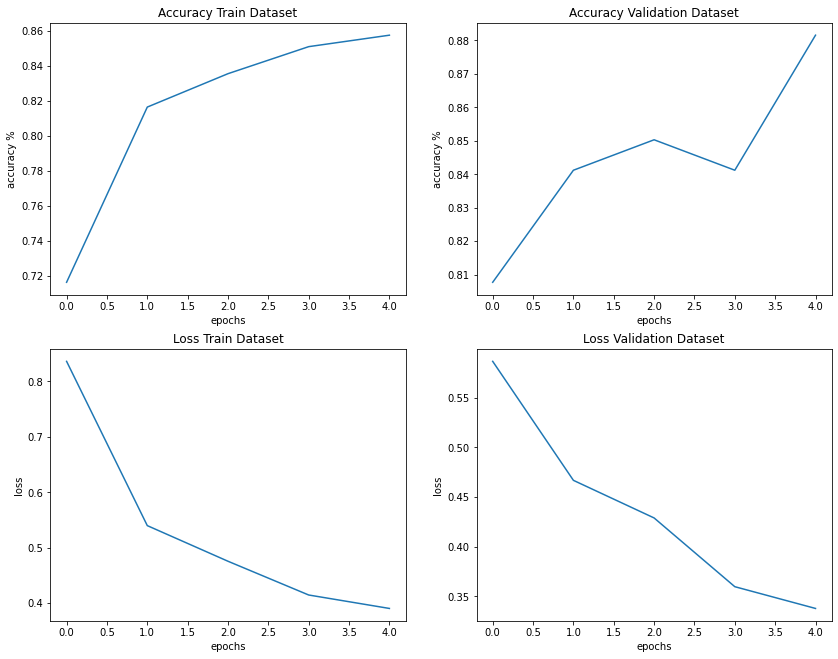

In [ ]:
print(training_lstm.history.keys())
estim_acc = training_lstm.history['accuracy']
valid_acc = training_lstm.history['val_accuracy']
estim_loss = training_lstm.history['loss']
valid_loss = training_lstm.history['val_loss']

### Plots
plt.figure(figsize=(14,11))
plt.subplot(2,2,1)
plt.plot(estim_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Train Dataset')
plt.subplot(2,2,2)
plt.plot(valid_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Validation Dataset') 
plt.subplot(2,2,3)
plt.plot(estim_loss)
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Loss Train Dataset') 
plt.subplot(2,2,4)
plt.plot(valid_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss Validation Dataset') 
plt.show()

In [ ]:
cnn_lstm.evaluate(ds_test_1d)

102/102 [==============================] - 4s 41ms/step - loss: 0.4936 - accuracy: 0.8406


[0.4935906231403351, 0.8406288623809814]

In [ ]:
cnn_lstm.save('cnn_lstm.h5')

## Inception module

In [ ]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, kernel_size=1, padding='same', activation='relu')(x)
    
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3_reduce, kernel_size=1, padding='same', activation='relu')(x)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, kernel_size=3, padding='same', activation='relu')(conv_3x3)

    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5_reduce, kernel_size=1, padding='same', activation='relu')(x)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, kernel_size=5, padding='same', activation='relu')(conv_5x5)

    pool_proj = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = tf.keras.layers.Concatenate(axis=-1, name=name)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output

In [ ]:
def build_CNN_inception(input_dim, output_dim):

  input = tf.keras.layers.Input(shape=input_dim)
  x = tf.keras.layers.BatchNormalization()(input)

  x = inception_module(input, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32, name='inception_layer_1')
  x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64, name='inception_layer_2')
  y = tf.keras.layers.Flatten()(x)
  y = tf.keras.layers.Dense(1024, activation="relu")(y)
  y = tf.keras.layers.Dropout(rate=0.3)(y)

  output = tf.keras.layers.Dense(output_dim, activation="softmax")(y)

  model = tf.keras.Model(inputs=input, outputs=output)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.95, beta_2 = 0.999, epsilon = 1e-08)
  loss = tf.keras.losses.CategoricalCrossentropy()
  accuracy = tf.keras.metrics.Accuracy()

  model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

  return model

In [ ]:
cnn_inception = build_CNN_inception(input_dim=X_2d.shape[1:], output_dim=y.shape[1])
cnn_inception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 28, 28, 96)   192         ['input_4[0][0]']                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 28, 28, 16)   32          ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 28, 28, 1)   0           ['input_4[0][0]']                
                                                                                            

In [ ]:
epochs = 10
training_inception = cnn_inception.fit(ds_estim_2d, epochs=epochs, validation_data=ds_valid_2d)

Epoch 1/10
365/365 [==============================] - 127s 341ms/step - loss: 19.6194 - accuracy: 0.7521 - val_loss: 0.4012 - val_accuracy: 0.8580
Epoch 2/10
365/365 [==============================] - 125s 341ms/step - loss: 0.4164 - accuracy: 0.8521 - val_loss: 0.2983 - val_accuracy: 0.8891
Epoch 3/10
365/365 [==============================] - 125s 342ms/step - loss: 0.3276 - accuracy: 0.8829 - val_loss: 0.2497 - val_accuracy: 0.9045
Epoch 4/10
365/365 [==============================] - 125s 343ms/step - loss: 0.2892 - accuracy: 0.8923 - val_loss: 0.2294 - val_accuracy: 0.9068
Epoch 5/10
365/365 [==============================] - 124s 341ms/step - loss: 0.2640 - accuracy: 0.9026 - val_loss: 0.2321 - val_accuracy: 0.9088
Epoch 6/10
365/365 [==============================] - 125s 342ms/step - loss: 0.2532 - accuracy: 0.9042 - val_loss: 0.2050 - val_accuracy: 0.9169
Epoch 7/10
365/365 [==============================] - 123s 338ms/step - loss: 0.2329 - accuracy: 0.9096 - val_loss: 0.2094 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


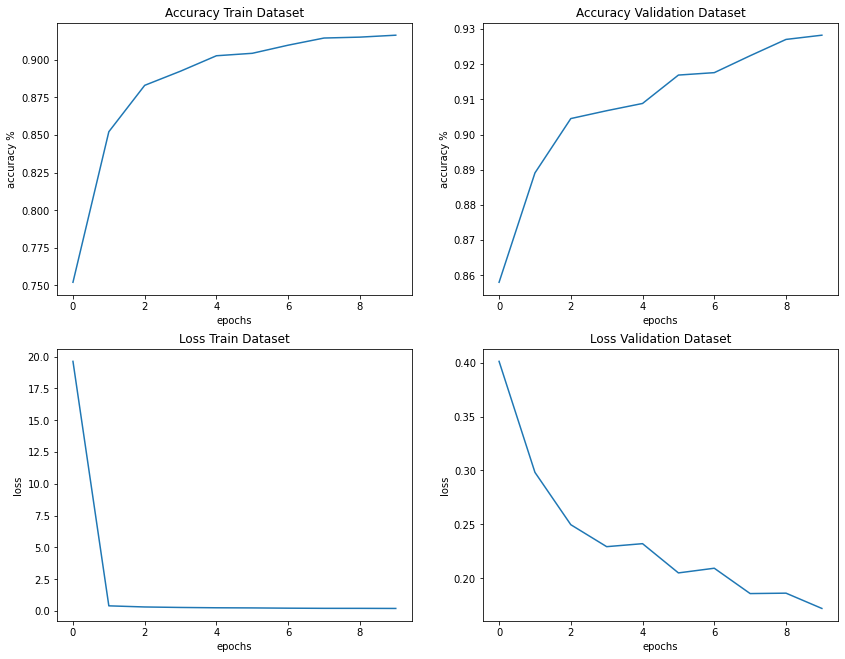

In [ ]:
print(training_inception.history.keys())
estim_acc = training_inception.history['accuracy']
valid_acc = training_inception.history['val_accuracy']
estim_loss = training_inception.history['loss']
valid_loss = training_inception.history['val_loss']

### Plots
plt.figure(figsize=(14,11))
plt.subplot(2,2,1)
plt.plot(estim_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Train Dataset')
plt.subplot(2,2,2)
plt.plot(valid_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Validation Dataset') 
plt.subplot(2,2,3)
plt.plot(estim_loss)
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Loss Train Dataset') 
plt.subplot(2,2,4)
plt.plot(valid_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss Validation Dataset') 
plt.show()

In [ ]:
cnn_inception.evaluate(ds_test_2d)

51/51 [==============================] - 5s 92ms/step - loss: 0.4993 - accuracy: 0.8523


[0.4993082284927368, 0.8523427844047546]

In [ ]:
cnn_inception.save('cnn_inception.h5')

## ICLSTM

In [33]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, kernel_size=1, padding='same', activation='relu')(x)
    
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3_reduce, kernel_size=1, padding='same', activation='relu')(x)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, kernel_size=3, padding='same', activation='relu')(conv_3x3)

    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5_reduce, kernel_size=1, padding='same', activation='relu')(x)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, kernel_size=5, padding='same', activation='relu')(conv_5x5)

    pool_proj = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = tf.keras.layers.Concatenate(axis=-1, name=name)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output

In [34]:
def layer_inception_module(x):

  x = tf.keras.layers.BatchNormalization()(x)

  x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32, name='inception_layer_1')
  x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64, name='inception_layer_2')

  y = tf.keras.layers.Flatten()(x)

  return y

In [35]:
def layer_lstm(x):

  x = tf.keras.layers.LSTM(3, return_sequences=True)(x)

  y = tf.keras.layers.Flatten()(x)

  return y

In [36]:
def build_CNN_iclstm(input_dim, output_dim):
  
  input_2d = tf.keras.layers.Input(shape=input_dim)
  input_1d = tf.reshape(input_2d, [-1, 784, 1])

  inception_layer = layer_inception_module(input_2d)
  lstm_layer = layer_lstm(input_1d)

  y = tf.keras.layers.Concatenate(axis=-1)([inception_layer, lstm_layer])

  y = tf.keras.layers.Dense(512, activation="relu")(y)
  y = tf.keras.layers.Dropout(rate=0.3)(y)

  output = tf.keras.layers.Dense(output_dim, activation="softmax")(y)

  model = tf.keras.Model(inputs=input_2d, outputs=output)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.95, beta_2 = 0.999, epsilon = 1e-08)
  loss = tf.keras.losses.CategoricalCrossentropy()
  accuracy = tf.keras.metrics.Accuracy()

  model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

  return model

In [37]:
cnn_iclstm = build_CNN_iclstm(input_dim=X_2d.shape[1:], output_dim=y.shape[1])
cnn_iclstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 1)   4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 96)   192         ['batch_normalization[0][0]']    
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 16)   32          ['batch_normalization[0][0]']

In [38]:
epochs = 1
training_iclstm = cnn_iclstm.fit(ds_estim_2d, epochs=epochs, validation_data=ds_valid_2d)

888/888 [==============================] - 99s 97ms/step - loss: 0.4822 - accuracy: 0.8053 - val_loss: 0.2410 - val_accuracy: 0.8627


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


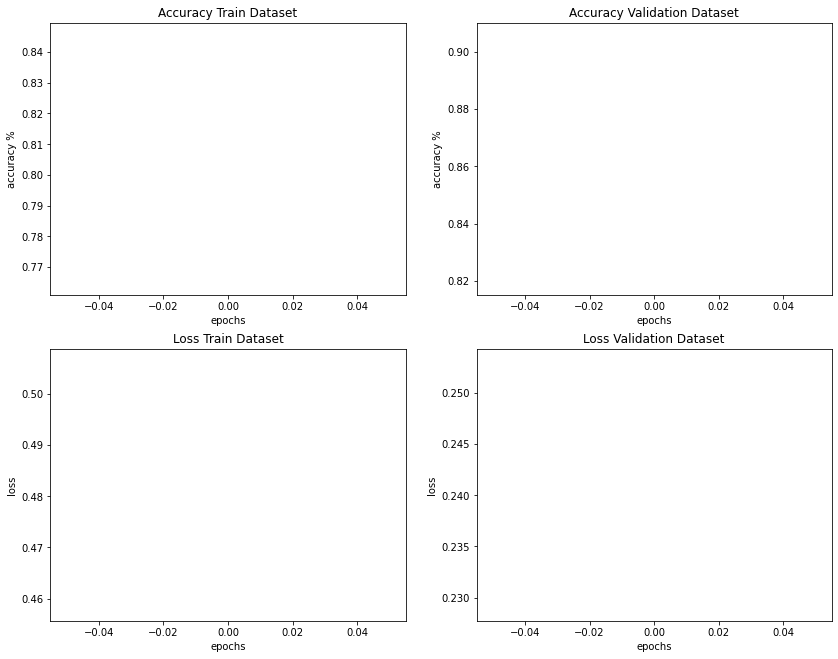

In [39]:
print(training_iclstm.history.keys())
estim_acc = training_iclstm.history['accuracy']
valid_acc = training_iclstm.history['val_accuracy']
estim_loss = training_iclstm.history['loss']
valid_loss = training_iclstm.history['val_loss']

### Plots
plt.figure(figsize=(14,11))
plt.subplot(2,2,1)
plt.plot(estim_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Train Dataset')
plt.subplot(2,2,2)
plt.plot(valid_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Validation Dataset') 
plt.subplot(2,2,3)
plt.plot(estim_loss)
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Loss Train Dataset') 
plt.subplot(2,2,4)
plt.plot(valid_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss Validation Dataset') 
plt.show()

In [47]:
cnn_iclstm.evaluate(ds_test_2d)

124/124 [==============================] - 4s 31ms/step - loss: 0.2547 - accuracy: 0.8603


[0.2546597123146057, 0.8603295087814331]

In [41]:
cnn_iclstm.save('cnn_iclstm.h5')

## Evaluation modèle

In [ ]:
tags = ["Chat", "Streaming", "FileTransfer", "P2P", "Email", "VoIP", 
        "VPN-Chat", "VPN-Streaming", "VPN-FileTransfer", "VPN-P2P", "VPN-Email", "VPN-VoIP"]

In [ ]:
def plot_conf_matrix(cf_matrix):
  """
  fonction permettant d'afficher la matrice de confusion
  """
  plt.figure(figsize=(14,11))

  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

  ax.set_title('Confusion Matrix with labels\n');
  ax.set_xlabel('\nPredicted Entity Category')
  ax.set_ylabel('Actual Entity Category ');

  ax.xaxis.set_ticklabels(tags)
  ax.yaxis.set_ticklabels(tags)

  plt.savefig('cf_matrix.png')

  plt.show()

In [ ]:
prediction_raw = cnn_inception.predict(ds_test_2d)

In [ ]:
L_preds, L_labels = [], label_test.tolist()

for output in prediction_raw:
  L_preds.append(tf.math.argmax(output, 0).numpy())

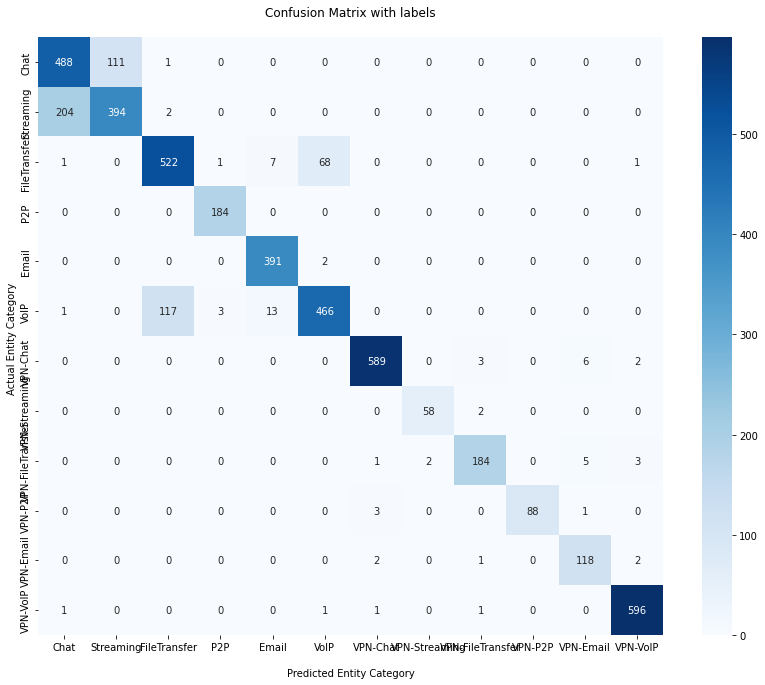

In [ ]:
cf_matrix = tf.math.confusion_matrix(L_labels, L_preds , num_classes=nb_classes)
plot_conf_matrix(cf_matrix)

In [ ]:
recall = np.diag(cf_matrix) / np.sum(cf_matrix, axis = 1)
precision = np.diag(cf_matrix) / np.sum(cf_matrix, axis = 0)

In [ ]:
for i, value in enumerate(tags):
  print('recall for {} : {}'.format(value, recall[i]))
  print('precision for {} : {}'.format(value, precision[i]))

recall for Chat : 0.8133333333333334
precision for Chat : 0.702158273381295
recall for Streaming : 0.6566666666666666
precision for Streaming : 0.7801980198019802
recall for FileTransfer : 0.87
precision for FileTransfer : 0.8130841121495327
recall for P2P : 1.0
precision for P2P : 0.9787234042553191
recall for Email : 0.9949109414758269
precision for Email : 0.9513381995133819
recall for VoIP : 0.7766666666666666
precision for VoIP : 0.8677839851024208
recall for VPN-Chat : 0.9816666666666667
precision for VPN-Chat : 0.988255033557047
recall for VPN-Streaming : 0.9666666666666667
precision for VPN-Streaming : 0.9666666666666667
recall for VPN-FileTransfer : 0.9435897435897436
precision for VPN-FileTransfer : 0.9633507853403142
recall for VPN-P2P : 0.9565217391304348
precision for VPN-P2P : 1.0
recall for VPN-Email : 0.959349593495935
precision for VPN-Email : 0.9076923076923077
recall for VPN-VoIP : 0.9933333333333333
precision for VPN-VoIP : 0.9867549668874173


In [ ]:
recall_mean = np.mean(recall)
precision_mean = np.mean(precision)
f1_score = 2*(recall_mean * precision_mean)/(recall_mean + precision_mean)

print('Précision globale du modèle \n')
print('recall : ', recall_mean)
print('precision : ', precision_mean)
print('F1-score : ', f1_score)

Précision globale du modèle 

recall :  0.9093921125854395
precision :  0.9088338128623069
F1-score :  0.9091128770088429


# Other method

## pre processing images (two layers)

In [ ]:
def two_layers_image(image):
  image_reshape = np.reshape(image, 784)

  i=783
  while image_reshape[i] == 0 and i >= 1:
    i-=1
  
  new_layer = np.zeros(784)
  try:
    new_layer[i] = 1
  except IndexError:
    pass
  image_2 = np.reshape(new_layer, [28,28, 1])

  image_1 = np.reshape(image, [28,28,1])
  result = np.concatenate((image_1, image_2), axis=-1)
  return result

In [ ]:
nsamples = data_train.shape[0]
data_train_two_layers = np.empty([nsamples, 28, 28, 2], dtype='int32')
for indice, image in enumerate(data_train):
  new_image = two_layers_image(image)
  data_train_two_layers[indice, :, :, :] = new_image

In [ ]:
nsamples = data_test.shape[0]
data_test_two_layers = np.empty([nsamples, 28, 28, 2], dtype='int32')
for indice, image in enumerate(data_test):
  new_image = two_layers_image(image)
  data_test_two_layers[indice, :, :, :] = new_image

In [ ]:
batch_size = 32

## dataset cnn 2d (two layers)

In [ ]:
# Conv 2D two layers
data_train_two_layers.shape

(35501, 28, 28, 2)

In [ ]:
y = tf.one_hot(label_train, nb_classes)
y.shape

TensorShape([35501, 12])

In [ ]:
ds_2d_2l = tf.data.Dataset.from_tensor_slices((data_train_two_layers, y))
n = ds_2d_2l.cardinality().numpy()

ds_2d_2l = ds_2d_2l.shuffle(n, reshuffle_each_iteration=True)
ds_2d_2l = ds_2d_2l.batch(batch_size).prefetch(batch_size).cache()

n_new = ds_2d_2l.cardinality().numpy()

ds_estim_2d_2l = ds_2d_2l.take(int(n_new * 0.8)) # Création du dataset d'estimation
ds_valid_2d_2l = ds_2d_2l.skip(int(n_new * 0.8)).take(int(n_new * 0.2)) # Création du dataset de validation

In [ ]:
# Création du dataset de test
y_test = tf.one_hot(label_test, nb_classes)
ds_test_2d_2l = tf.data.Dataset.from_tensor_slices((data_test_two_layers, y_test))
ds_test_2d_2l = ds_test_2d_2l.batch(batch_size).prefetch(batch_size).cache()

## dataset cnn 1d (two layers)

In [ ]:
# Conv 2D two layers
data_train_two_layers = np.reshape(data_train_two_layers, [-1, 784, 2])
data_train_two_layers.shape

(35501, 784, 2)

In [ ]:
y = tf.one_hot(label_train, nb_classes)
y.shape

TensorShape([35501, 12])

In [ ]:
ds_2d_2l = tf.data.Dataset.from_tensor_slices((data_train_two_layers, y))
n = ds_2d_2l.cardinality().numpy()

ds_2d_2l = ds_2d_2l.shuffle(n, reshuffle_each_iteration=True)
ds_2d_2l = ds_2d_2l.batch(batch_size).prefetch(batch_size).cache()

n_new = ds_2d_2l.cardinality().numpy()

ds_estim_2d_2l = ds_2d_2l.take(int(n_new * 0.8)) # Création du dataset d'estimation
ds_valid_2d_2l = ds_2d_2l.skip(int(n_new * 0.8)).take(int(n_new * 0.2)) # Création du dataset de validation

In [ ]:
# Création du dataset de test
data_test_two_layers = np.reshape(data_test_two_layers, [-1, 784,2])
y_test = tf.one_hot(label_test, nb_classes)
ds_test_2d_2l = tf.data.Dataset.from_tensor_slices((data_test_two_layers, y_test))
ds_test_2d_2l = ds_test_2d_2l.batch(batch_size).prefetch(batch_size).cache()

## CNN 2D (two layers)

In [ ]:
def build_CNN_2D(input_dim, output_dim):
  
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Input(shape=input_dim))

  model.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=1, padding='same'))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(strides=2, padding='same'))

  model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same'))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(strides=2, padding='same'))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1024))
  model.add(tf.keras.layers.Dropout(rate=0.3))

  model.add(tf.keras.layers.Dense(output_dim, activation="softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.95, beta_2 = 0.999, epsilon = 1e-08)
  loss = tf.keras.losses.CategoricalCrossentropy()
  accuracy = tf.keras.metrics.Accuracy()

  model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

  return model

In [ ]:
cnn_2d = build_CNN_2D(input_dim=data_train_two_layers.shape[1:], output_dim=y.shape[1])
cnn_2d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        1632      
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [ ]:
epochs = 10
training_2d = cnn_2d.fit(ds_estim_2d_2l, epochs=epochs, validation_data=ds_valid_2d_2l)

Epoch 1/10
888/888 [==============================] - 20s 12ms/step - loss: 1.3312 - accuracy: 0.7179 - val_loss: 0.5680 - val_accuracy: 0.7609
Epoch 2/10
888/888 [==============================] - 9s 10ms/step - loss: 0.5095 - accuracy: 0.7744 - val_loss: 0.4799 - val_accuracy: 0.7894
Epoch 3/10
888/888 [==============================] - 9s 11ms/step - loss: 0.4661 - accuracy: 0.7891 - val_loss: 0.4650 - val_accuracy: 0.7920
Epoch 4/10
888/888 [==============================] - 10s 11ms/step - loss: 0.4355 - accuracy: 0.7987 - val_loss: 0.4400 - val_accuracy: 0.8027
Epoch 5/10
888/888 [==============================] - 9s 11ms/step - loss: 0.4038 - accuracy: 0.8091 - val_loss: 0.4151 - val_accuracy: 0.8147
Epoch 6/10
888/888 [==============================] - 9s 10ms/step - loss: 0.3805 - accuracy: 0.8203 - val_loss: 0.4074 - val_accuracy: 0.8162
Epoch 7/10
888/888 [==============================] - 9s 10ms/step - loss: 0.3590 - accuracy: 0.8296 - val_loss: 0.4075 - val_accuracy: 0.82

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


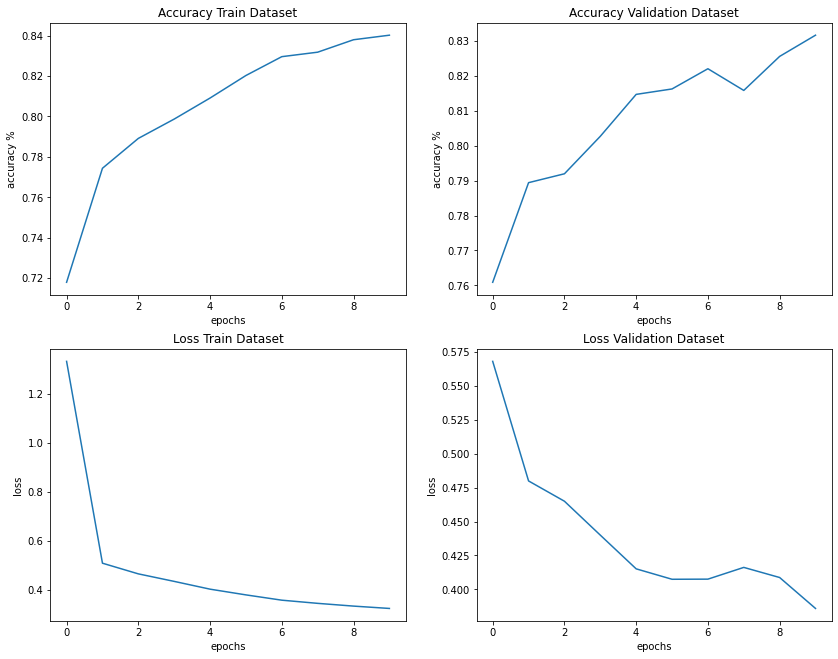

In [ ]:
print(training_2d.history.keys())
estim_acc = training_2d.history['accuracy']
valid_acc = training_2d.history['val_accuracy']
estim_loss = training_2d.history['loss']
valid_loss = training_2d.history['val_loss']

### Plots
plt.figure(figsize=(14,11))
plt.subplot(2,2,1)
plt.plot(estim_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Train Dataset')
plt.subplot(2,2,2)
plt.plot(valid_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Validation Dataset') 
plt.subplot(2,2,3)
plt.plot(estim_loss)
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Loss Train Dataset') 
plt.subplot(2,2,4)
plt.plot(valid_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss Validation Dataset') 
plt.show()

In [ ]:
cnn_2d.evaluate(ds_test_2d_2l)

124/124 [==============================] - 1s 5ms/step - loss: 0.3671 - accuracy: 0.8269


[0.36708706617355347, 0.8268694281578064]

In [ ]:
cnn_2d.save('cnn_2d.h5')

## LSTM

In [ ]:
def build_CNN_LSTM(input_dim, output_dim):
  
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Input(shape=input_dim))

  model.add(tf.keras.layers.LSTM(3, return_sequences=True))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(512))
  model.add(tf.keras.layers.Dropout(rate=0.3))

  model.add(tf.keras.layers.Dense(output_dim, activation="softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.95, beta_2 = 0.999, epsilon = 1e-08)
  loss = tf.keras.losses.CategoricalCrossentropy()
  accuracy = tf.keras.metrics.Accuracy()

  model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

  return model

In [ ]:
cnn_lstm = build_CNN_LSTM(input_dim=data_train_two_layers.shape[1:], output_dim=y.shape[1])
cnn_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 784, 3)            72        
                                                                 
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1204736   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                6156      
                                                                 
Total params: 1,210,964
Trainable params: 1,210,964
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 5
training_lstm = cnn_lstm.fit(ds_estim_2d_2l, epochs=epochs, validation_data=ds_valid_2d_2l)

Epoch 1/5
888/888 [==============================] - 97s 104ms/step - loss: 0.4995 - accuracy: 0.7842 - val_loss: 0.3519 - val_accuracy: 0.8267
Epoch 2/5
888/888 [==============================] - 91s 103ms/step - loss: 0.3469 - accuracy: 0.8347 - val_loss: 0.3381 - val_accuracy: 0.8378
Epoch 3/5
888/888 [==============================] - 92s 104ms/step - loss: 0.3068 - accuracy: 0.8462 - val_loss: 0.3238 - val_accuracy: 0.8387
Epoch 4/5
888/888 [==============================] - 92s 103ms/step - loss: 0.2817 - accuracy: 0.8533 - val_loss: 0.3049 - val_accuracy: 0.8442
Epoch 5/5
888/888 [==============================] - 92s 104ms/step - loss: 0.2574 - accuracy: 0.8581 - val_loss: 0.2974 - val_accuracy: 0.8497


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


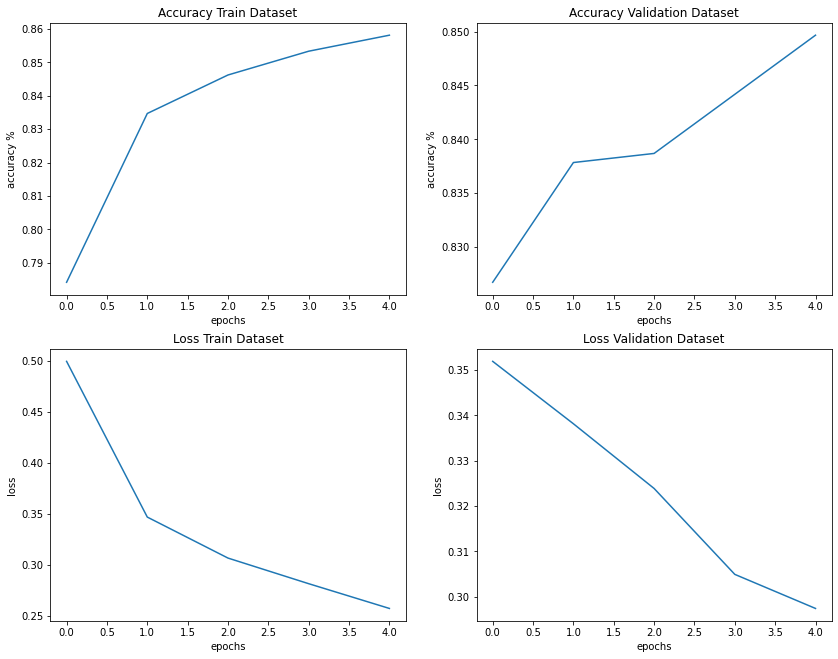

In [ ]:
print(training_lstm.history.keys())
estim_acc = training_lstm.history['accuracy']
valid_acc = training_lstm.history['val_accuracy']
estim_loss = training_lstm.history['loss']
valid_loss = training_lstm.history['val_loss']

### Plots
plt.figure(figsize=(14,11))
plt.subplot(2,2,1)
plt.plot(estim_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Train Dataset')
plt.subplot(2,2,2)
plt.plot(valid_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Validation Dataset') 
plt.subplot(2,2,3)
plt.plot(estim_loss)
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Loss Train Dataset') 
plt.subplot(2,2,4)
plt.plot(valid_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss Validation Dataset') 
plt.show()

In [ ]:
cnn_lstm.evaluate(ds_test_2d_2l)

124/124 [==============================] - 5s 42ms/step - loss: 0.3028 - accuracy: 0.8499


[0.3027992248535156, 0.8499366044998169]

In [ ]:
cnn_lstm.save('cnn_lstm.h5')

# Optimisation du modèle ICLSTM

In [99]:
def gridsearch_NN(function_model, params):

  # Grid Search
  keys = params.keys()
  combinations = itertools.product(*params.values())
  grid_params = [dict(zip(keys,cc)) for cc in combinations]

  # Try each model
  best_score, best_params, historique = 0, {}, []
  for current_params in grid_params:
    model = function_model(input_dim=X_2d.shape[1:], output_dim=y.shape[1], nb_nn_dense=current_params['nb_nn_dense'])
    model.fit(ds_estim_2d, epochs=1, validation_data=ds_valid_2d)
    score = model.evaluate(ds_test_2d)[1]
    historique.append((current_params, score))

    # Replace by best score
    if score > best_score:
      best_score = score
      best_params = current_params
      best_model = model

  # Return best model and best params    
  return best_model, best_params, historique

In [100]:
def build_CNN_iclstm_params(input_dim, output_dim, nb_nn_dense=512):
  
  input_2d = tf.keras.layers.Input(shape=input_dim)
  input_1d = tf.reshape(input_2d, [-1, 784, 1])

  inception_layer = layer_inception_module(input_2d)
  lstm_layer = layer_lstm(input_1d)

  y = tf.keras.layers.Concatenate(axis=-1)([inception_layer, lstm_layer])

  y = tf.keras.layers.Dense(nb_nn_dense, activation="relu")(y)
  y = tf.keras.layers.Dropout(rate=0.3)(y)

  output = tf.keras.layers.Dense(output_dim, activation="softmax")(y)

  model = tf.keras.Model(inputs=input_2d, outputs=output)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.95, beta_2 = 0.999, epsilon = 1e-08)
  loss = tf.keras.losses.CategoricalCrossentropy()

  model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

  return model

In [101]:
params = {
    'nb_nn_dense' : [512, 256, 128, 64]
}

In [102]:
best_model, best_params, historique = gridsearch_NN(build_CNN_iclstm_params, params)

124/124 [==============================] - 3s 20ms/step - loss: 0.3362 - accuracy: 0.8413


In [103]:
historique

[({'nb_nn_dense': 512}, 0.8583016395568848),
 ({'nb_nn_dense': 256}, 0.8572877049446106),
 ({'nb_nn_dense': 128}, 0.8633713722229004),
 ({'nb_nn_dense': 64}, 0.8413181304931641)]

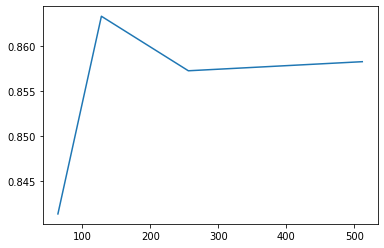

In [120]:
plt.plot([i[0]['nb_nn_dense'] for i in historique],[i[1] for i in historique])

In [104]:
best_params

{'nb_nn_dense': 128}